In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('bank-full.csv', sep=';')

Выборка необходимых признаков

In [56]:
selected_columns = ['age', 'job', 'marital', 'education', 'balance', 'housing',
                    'contact', 'day', 'month', 'duration', 'campaign',
                    'pdays', 'previous', 'poutcome', 'y']
df = df[selected_columns]

df.isnull().sum()

,0
age,0
job,0
marital,0
education,0
balance,0
housing,0
contact,0
day,0
month,0
duration,0


In [57]:
from sklearn.model_selection import train_test_split

X = df.drop('y', axis=1)
y = df['y']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)


Вопрос 1

In [58]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import numpy as np

numerical_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

auc_scores = {}

for feature in numerical_features:
    model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=1)
    X_train_feature = X_train[[feature]]
    model.fit(X_train_feature, y_train)
    y_pred = model.predict_proba(X_train_feature)[:, 1]
    auc = roc_auc_score(y_train, y_pred)

    if auc < 0.5:
        auc_scores[feature] = -auc
    else:
        auc_scores[feature] = auc

print(auc_scores)

max_auc_feature = max(auc_scores, key=auc_scores.get)
print(f"Числовая переменная с наивысшим AUC: {max_auc_feature}")


{'age': -0.48748941184002925, 'balance': 0.5916931412945473, 'day': 0.5291275984648961, 'duration': 0.8128648066681694, 'campaign': 0.5742447701740003, 'pdays': 0.5897967289320412, 'previous': 0.5986704105715122}
Числовая переменная с наивысшим AUC: duration


Вопрос 2

In [59]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

X_train_dict = X_train.to_dict(orient='records')
X_valid_dict = X_valid.to_dict(orient='records')

vec = DictVectorizer(sparse=False)
X_train_encoded = vec.fit_transform(X_train_dict)
X_valid_encoded = vec.transform(X_valid_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train)

y_valid_pred = model.predict_proba(X_valid_encoded)[:, 1]
auc = roc_auc_score(y_valid, y_valid_pred)

print(f"AUC модели на валидационном наборе: {round(auc, 3)}")


AUC модели на валидационном наборе: 0.9


Вопрос 3

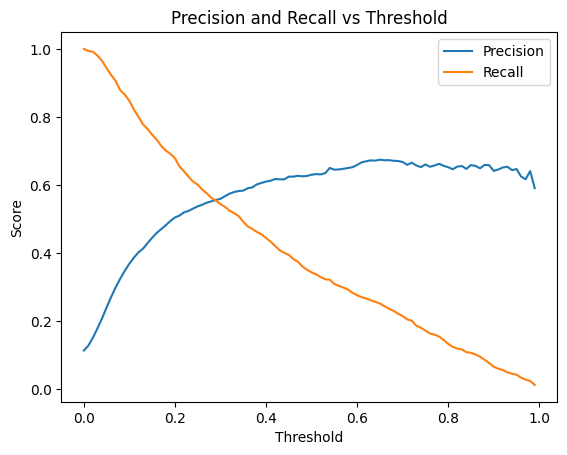

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

precision_values = []
recall_values = []

thresholds = np.arange(0.0, 1.0, 0.01)

y = y.map({'yes': 1, 'no': 0})

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

for threshold in thresholds:
    y_pred = (y_valid_pred >= threshold).astype(int)
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)

    precision_values.append(precision)
    recall_values.append(recall)

plt.plot(thresholds, precision_values, label='Precision')
plt.plot(thresholds, recall_values, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.show()

for threshold, precision, recall in zip(thresholds, precision_values, recall_values):
    if round(precision, 3) == round(recall, 3):
        print(f"Precision и Recall пересекаются при пороге {threshold:.3f}")


Вопрос 4

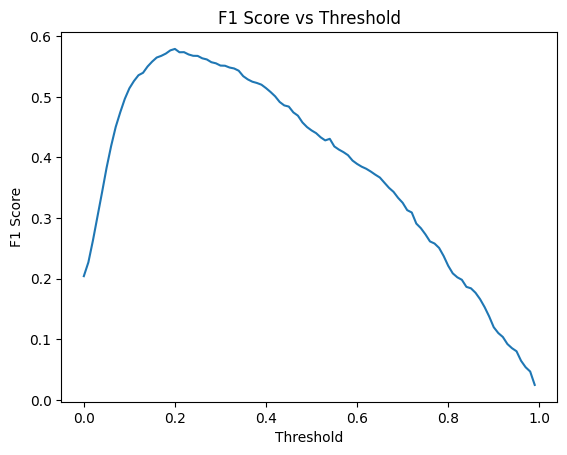

Порог, при котором F1 достигает максимума: 0.20


In [62]:
from sklearn.metrics import f1_score

f1_values = []

for threshold in thresholds:
    y_pred = (y_valid_pred >= threshold).astype(int)
    f1 = f1_score(y_valid, y_pred)
    f1_values.append(f1)

plt.plot(thresholds, f1_values, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.show()

best_threshold = thresholds[np.argmax(f1_values)]
print(f"Порог, при котором F1 достигает максимума: {best_threshold:.2f}")


Вопрос 5

In [63]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

kf = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores_kfold = []

for train_index, val_index in kf.split(X_train_encoded):
    X_train_fold, X_valid_fold = X_train_encoded[train_index], X_train_encoded[val_index]
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    model.fit(X_train_fold, y_train_fold)
    y_valid_pred_fold = model.predict_proba(X_valid_fold)[:, 1]
    auc = roc_auc_score(y_valid_fold, y_valid_pred_fold)
    auc_scores_kfold.append(auc)

std_error = np.std(auc_scores_kfold)
print(f"Стандартная ошибка оценок на разных фолдах: {round(std_error, 3)}")


Стандартная ошибка оценок на разных фолдах: 0.004


Вопрос 6

In [64]:

C_values = [0.000001, 0.001, 1]
mean_aucs = []
std_aucs = []

for C_val in C_values:
    auc_scores_for_C = []
    for train_index, val_index in kf.split(X_train_encoded):
        X_train_fold, X_valid_fold = X_train_encoded[train_index], X_train_encoded[val_index]
        y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        model = LogisticRegression(solver='liblinear', C=C_val, max_iter=1000)
        model.fit(X_train_fold, y_train_fold)
        y_valid_pred_fold = model.predict_proba(X_valid_fold)[:, 1]
        auc = roc_auc_score(y_valid_fold, y_valid_pred_fold)
        auc_scores_for_C.append(auc)

    mean_auc = np.mean(auc_scores_for_C)
    std_auc = np.std(auc_scores_for_C)

    mean_aucs.append(mean_auc)
    std_aucs.append(std_auc)